(connectivite-chapitre)=
# Connectivité fonctionnelle

<table>
  <tr>
    <td align="center">
      <a href="https://github.com/sangfrois">
        <img src="https://avatars.githubusercontent.com/u/38385719?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>François Lespinasse</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
        <a title="Révision du texte">👀</a>
    </td>
    <td align="center">
      <a href="https://github.com/pbellec">
        <img src="https://avatars.githubusercontent.com/u/1670887?v=4?s=100" width="100px;" alt=""/>
        <br /><sub><b>Pierre bellec</b></sub>
      </a>
      <br />
        <a title="Contenu">🤔</a>
        <a title="Code">💻</a>
        <a title="Exercices">⚠️</a>
        <a title="Révision du texte">👀</a>
    </td>
  </tr>
</table>

```{warning}
Ce chapitre va être mis à jour à l'automne 2022. En particulier les exercices vont être révisés, et certains exercices pourraient être ajoutés ou supprimés.
```

## Objectifs
Dans le chapitre sur les [cartes d'activation en IRMf](irm_fonctionnelle), nous avons vu que ce type d'analyse met l'emphase sur la notion de ségrégation fonctionnelle, c'est à dire à quel point certaines régions cérébrales sont engagées spécifiquement par une certaine catégorie de processus cognitifs. Mais il est bien connu que les processus cognitifs requièrent aussi un certain degré d'**intégration fonctionnelle**, où différentes régions du cerveau interagissent ensemble pour effectuer une tâche. Cette notion d'intégration amène à concevoir le cerveau comme un réseau, ou encore un graphe, qui décrit la **connectivité fonctionnelle** entre régions du cerveau. Ce chapitre introduit des notions de base utilisées pour étudier la connectivité du cerveau à l'aide de l'IRMf.

```{figure} connectivite/brain-graph-fig.png
---
width: 400px
name: brain-graph-fig
---
Graphe de connectivité fonctionnelle moyen sur le jeu de données ADHD-200. Chaque noeud du graphe représente une région de cerveau, et les connexions représentent la connectivité fonctionnelle moyenne sur le jeu de données ADHD-200 {cite:p}`HD-200_Consortium2012-uv`, après seuillage. L'échelle de couleur et la taille des noeuds représentent le nombre de connexions (degré) associé à chaque noeud. Le graphe est généré à l'aide de la librairie [gephi](https://gephi.org/). La figure est tirée de {cite:p}`BELLEC2017275`, sous licence CC-BY.
```

Les objectifs spécifiques du chaptire sont de:
*   Comprendre la définition de la **connectivité fonctionnelle**.
*   Comprendre la distinction entre activité **intrinsèque** et **évoquée**.
*   Comprendre la notion de **réseau fonctionnel**.
*   Connaître les **principaux réseaux au repos**.


## Carte de connectivité fonctionnelle

/home/pbellec/env/psy3018/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


Time series with shape (261, 122) (# time points, # parcels))


Time series with shape (261, 76297) (# time points, # voxels))


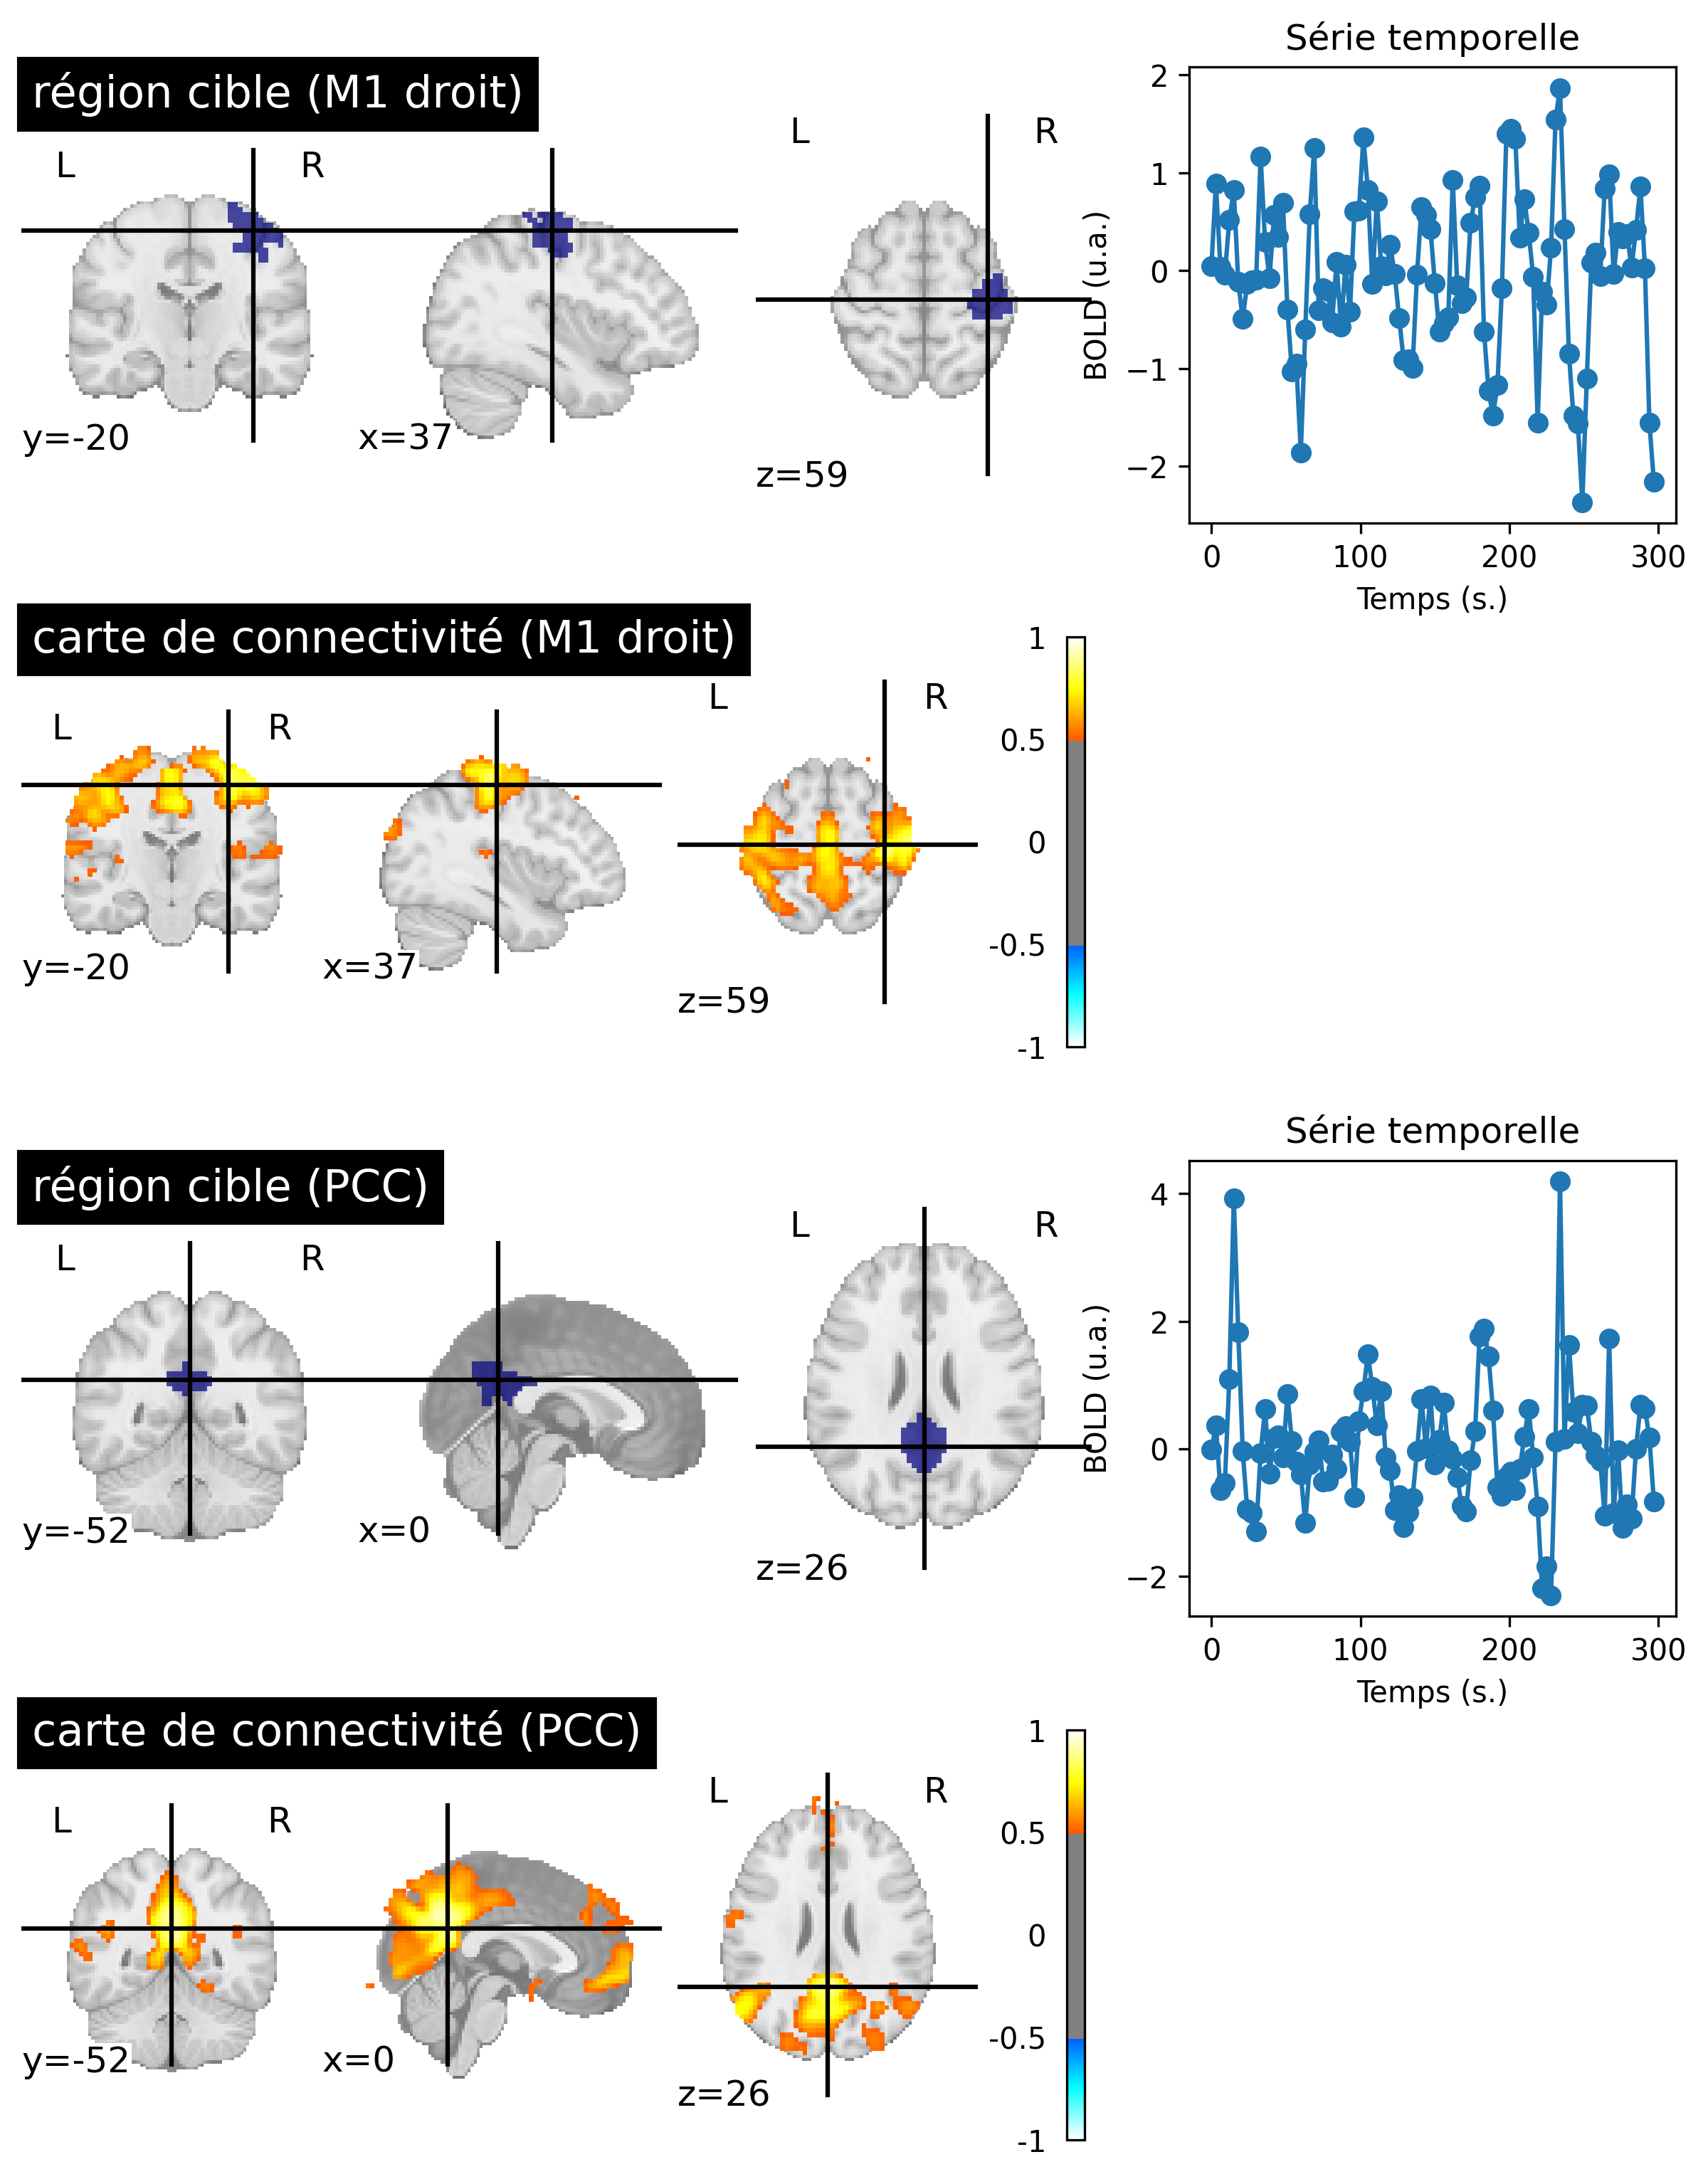

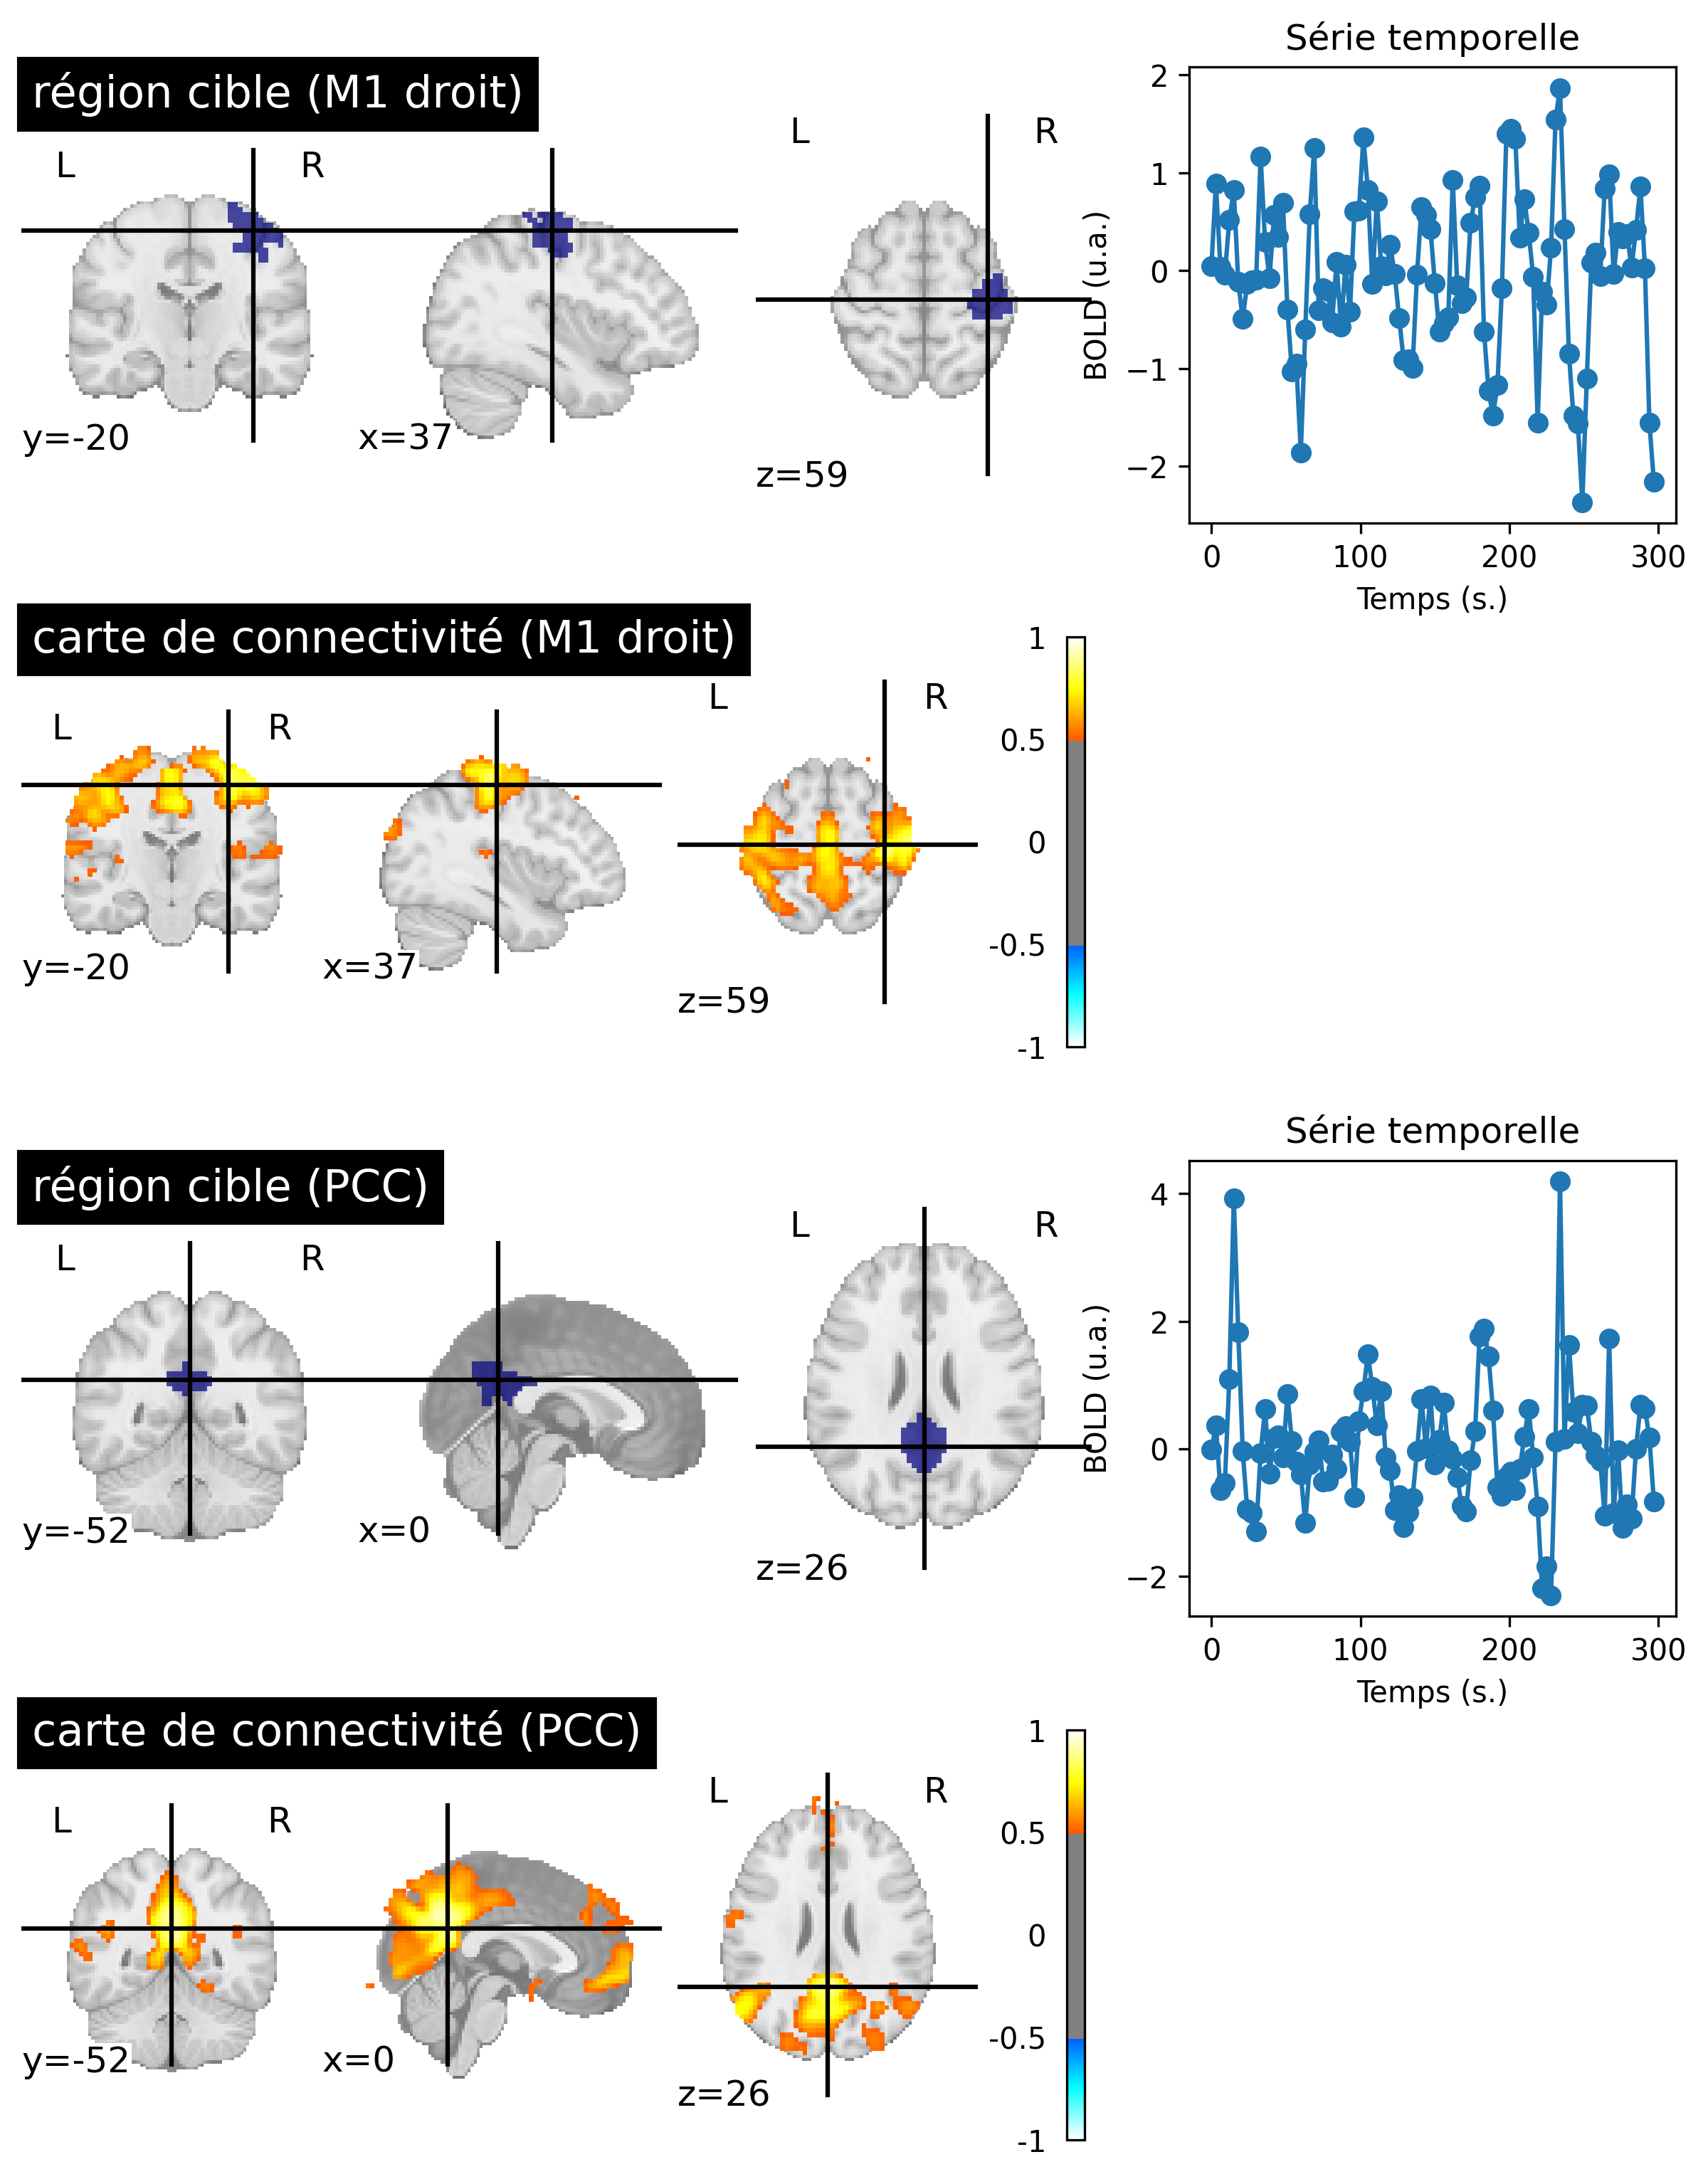

In [1]:
# Importe les librairies
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image import math_img
from nilearn import plotting, input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn import datasets # Fetch data using nilearn
from nilearn.input_data import NiftiMasker


import warnings
warnings.filterwarnings("ignore")

# Initialise la figure
fig = plt.figure(figsize=(10, 13), dpi=300)

# Importe les données
basc = datasets.fetch_atlas_basc_multiscale_2015() # the BASC multiscale atlas
adhd = datasets.fetch_adhd(n_subjects=10)          # ADHD200 preprocessed data (Athena pipeline)\

# Paramètres du pré-traitement
num_data = 6
fwhm = 8
high_pass = 0.01
high_variance_confounds = False
time_samp = range(0, 100)

# Extrait le signal par parcelle pour un atlas fonctionnel (BASC)
masker = input_data.NiftiLabelsMasker(
                                      basc['scale122'],
                                      resampling_target="data",
                                      high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      memory_level=1,
                                      smoothing_fwhm=fwhm).fit()
tseries = masker.transform(adhd.func[num_data])
print(f"Time series with shape {tseries.shape} (# time points, # parcels))")

# Charge les données par voxel
masker_voxel = input_data.NiftiMasker(high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      smoothing_fwhm=fwhm
                                     ).fit(adhd.func[num_data])
tseries_voxel = masker_voxel.transform(adhd.func[num_data])
print(f"Time series with shape {tseries_voxel.shape} (# time points, # voxels))")

# Montre une parcelle
ax_plot = plt.subplot2grid((4, 3), (0, 0), colspan=2)
num_parcel = 73
plotting.plot_roi(math_img(f'img == {num_parcel}', img=basc['scale122']),
                  threshold=0.5,
                  axes=ax_plot,
                  vmax=1,
                  title="région cible (M1 droit)")

# plot la série temporelle d'une région
ax_plot = plt.subplot2grid((4, 3), (0, 2), colspan=1)
time = np.linspace(0, 3 * (tseries.shape[0]-1), tseries.shape[0])
plt.plot(time[time_samp], tseries[time_samp, :][:, num_parcel], 'o-'),
plt.xlabel('Temps (s.)'),
plt.ylabel('BOLD (u.a.)')
plt.title('Série temporelle')

# carte de connectivité
ax_plot = plt.subplot2grid((4, 3), (1, 0), colspan=2)
seed_to_voxel_correlations = (np.dot(tseries_voxel.T, tseries[:, num_parcel-1]) / tseries.shape[0])# Show the connectivity map
conn_map = masker_voxel.inverse_transform(seed_to_voxel_correlations.T)
plotting.plot_stat_map(conn_map,
                       threshold=0.5,
                       vmax=1,
                       axes=ax_plot,
                       cut_coords=(37, -20, 59),
                       title="carte de connectivité (M1 droit)")

# Montre une parcelle
num_parcel = 17
ax_plot = plt.subplot2grid((4, 3), (2, 0), colspan=2)
plotting.plot_roi(math_img(f'img == {num_parcel}', img=basc['scale122']),
                  threshold=0.5,
                  vmax=1,
                  axes=ax_plot,
                  title="région cible (PCC)")

# plot la série temporelle d'une région
ax_plot = plt.subplot2grid((4, 3), (2, 2), colspan=1)
time = np.linspace(0, 3 * (tseries.shape[0]-1), tseries.shape[0])
plt.plot(time[time_samp], tseries[time_samp, :][:, num_parcel], 'o-'),
plt.xlabel('Temps (s.)'),
plt.ylabel('BOLD (u.a.)')
plt.title('Série temporelle')


# carte de connectivité
ax_plot = plt.subplot2grid((4, 3), (3, 0), colspan=2)
seed_to_voxel_correlations = (np.dot(tseries_voxel.T, tseries[:, num_parcel-1]) / tseries.shape[0])# Show the connectivity map
conn_map = masker_voxel.inverse_transform(seed_to_voxel_correlations.T)
plotting.plot_stat_map(conn_map,
                       threshold=0.5,
                       cut_coords=(0, -52, 26),
                       vmax=1,
                       axes=ax_plot,
                       title="carte de connectivité (PCC)")

from myst_nb import glue
glue("fcmri-map-fig", fig, display=False)

```{glue:figure} fcmri-map-fig
:figwidth: 600px
:name: fcmri-map-fig
:align: center
Cartes de connectivité au repos générées à partir des données IRMf d'un individu du jeu de données ADHD-200 {cite:p}`HD-200_Consortium2012-uv`. Pour chaque carte, la région cible utilisée ainsi que les cinq premières minutes d'activité BOLD associée à la région cible sont représentées. Cette figure est générée par du code python à l'aide de la librairie [nilearn](https://nilearn.github.io/) (cliquer sur + pour voir le code), et est distribuée sous licence CC-BY.
```

Avant de parler de connectivité fonctionnelle, revisitons le concept de cartes d'activation en IRMf. Comme nous l'{ref}`avons vu <activation-section>`, on génère une carte d'activation en comparant les fluctuations BOLD dans une région donnée du cerveau avec une prédiction de la réponse cérébrale associée à une tâche. De manière simplifiée, la carte d'activation nous montre la corrélation entre l'activité attendue (sur la base du paradigme expérimentale et d'une fonction de réponse hémodynamique) et l'activité mesurée à chaque voxel.

Une carte de connectivité relève un peu de la même logique. Mais au lieu de nous intéresser à la réponse attendue en réponse à une tâche, nous allons nous intéresser à l'activité d'une région particulière du cerveau, appelée **région cible**. Nous allons alors mesurer la corrélation entre le décours temporel de chaque voxel dans le cerveau et décours temporel de la région cible. Nous allons obtenir une **carte de connectivité fonctionnelle** qui nous montre quelles régions du cerveau ont une activité très corrélée (ou synchrone) avec la région cible.

```{admonition} Mesure de corrélation
:class: tip
:name: corrélation

La [corrélation](https://fr.wikipedia.org/wiki/Corr%C3%A9lation_(statistiques)) entre deux séries temporelles est une mesure qui varie entre -1 et 1. Si les deux séries sont identiques (à leur moyenne et variance près), la corrélation est de 1. Si les deux séries sont statistiquement indépendantes, la corrélation est proche de zéro. Si les deux séries sont mirroirs l'une de l'autre, la corrélation est de -1.
```
La ***connectivité fonctionnelle*** est un terme relativement générique utilisé pour décrire un ensemble de techniques permettant d'analyser les patterns spatiaux de l'activité cérébrale {cite:p}`Fox2007`. Fox et Raischle (2007) propose que la technique la plus simple pour mener ce genre d'analyse est effectivement d'extraire le décours temporel BOLD d'une **région cible** et d'en déterminer la corrélation d'avec le reste des voxels. Des techniques plus sophistiquées ont été développées afin de surpasser les limites de cette modélisation. Elles seront discuté à la fin de ce chapitre.

Le concept de carte fonctionnelle a été introduit par Biswal et collègues (1995) {cite:p}`Biswal1995-lw`, en utilisant une cible dans le cortex sensorimoteur primaire droit. Cette région cible avait été obtenue avec une carte d'activation et une tâche motrice. Biswal et collègues ont alors eu l'idée d'observer les fluctuations BOLD dans une condition de **repos**, en l'absence de tâche expérimentale. Cette carte révèle un ensemble distribué de régions (voir {numref}`fcmri-map-fig`, cible M1 droit), qui comprend le cortex sensorimoteur gauche, mais aussi l'aire motrice supplémentaire, le cortex prémoteur et d'autres régions du cerveau connues pour leur implication dans le **réseau moteur**. Cette étude a tout d'abord engendré beaucoup de septicisme, au motif que ces patrons d'activité fonctionnelle corrélée aurait pu refléter du bruit cardiaque ou respiratoire.

```{admonition} Fluctuations lentes
:class: tip
:name: fluctuations-lentes
Une autre observation clé de Biswal et collègues (1995) {cite:p}`Biswal1995-lw` est que le signal BOLD au repos est dominé par des fluctuations lentes, avec des bouffées d'activité d'une durée de 20 à 30 secondes, clairement visibles dans la {numref}`fcmri-map-fig`. Plus spécifiquement, le spectre du signal BOLD au repos est dominée par les fréquences inférieures à 0.08 Hz, et même 0.03-0.05 Hz.
```
La crédibilité des cartes de connectivité au repos s'est renforcée quand différents groupes de recherche ont pu identifié d'autres réseaux en utilisant des régions cibles différentes, notamment le réseau visuel et le réseau auditif. Mais c'est l'étude de Greicius et collaborateurs, en 2003 {cite:p}`Greicius2003-hi`, qui a déclenché un énorme intérêt pour les cartes de connectivité au repos en utilisant une région cible dans le cortex cingulaire postérieur (PCC) pour identifier un réseau fonctionnel qui n'avait pas encore été identifié: le **réseau du mode par défaut** (voir {numref}`fcmri-map-fig`, cible PCC). Nous allons discuter dans la prochaine section des origines de ce réseau, et comment il peut nous aider à comprendre ce que mesure la connectivité au repos. Il est également important de mentionner que le travail de Shmuel et collèges (2008) {cite:p}`Shmuel2008-pa` a démontré que l'activité BOLD au repos corrèle aux fluctuations spontanées d'activité neuronales dans le cortex visuel d'un macaque anésthésié, ce qui démontre que la connectivité fonctionnelle reflète au moins partiellement la synchronie de l'activité neuronale, et pas simplement du bruit physiologique (cardiaque, respiration).

```{admonition} Variabilité intra- et inter-individuelle
:class: caution attention
:name: fcmri-map-warning
La {numref}`fcmri-map-fig` peut donner l'impression que les réseaux de connectivité sont extrêmement stables. En réalité, les cartes de connectivité varient beaucoup au cours du temps, c'est à dire en regardant différentes fenêtres d'activité pour un même individu, et également entre individus. Effectivement, les coordonnées d'une région cible peuvent être partiellement inexactes même si on procède au recalage des images. Caractériser la variabilité intra- et inter-individuelle des cartes de connectivité est un domaine de recherche actif.
```
## Le réseau du mode par défaut

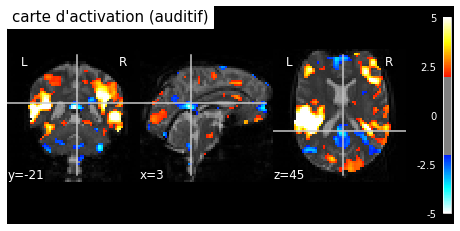

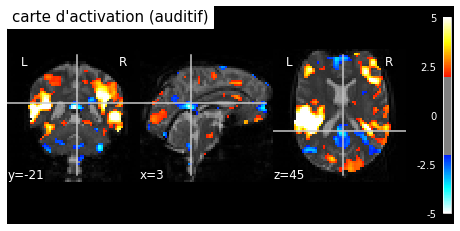

In [2]:
# Importe les librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets
from nilearn.image import math_img
from nilearn import image
from nilearn import masking
from nilearn.glm.first_level import FirstLevelModel
from nilearn import input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from nilearn import plotting

# initialisation de la figure
fig = plt.figure(figsize=(8, 4))

# load fMRI data
subject_data = datasets.fetch_spm_auditory()
fmri_img = image.concat_imgs(subject_data.func)

# Make an average
mean_img = image.mean_img(fmri_img)
mask = masking.compute_epi_mask(mean_img)

# Clean and smooth data
fmri_img = image.clean_img(fmri_img, high_pass=0.01, t_r=7, standardize=False)
fmri_img = image.smooth_img(fmri_img, 8.)

# load events
events = pd.read_table(subject_data['events'])

# Fit model
fmri_glm = FirstLevelModel(t_r=7,
                           drift_model='cosine',
                           signal_scaling=False,
                           mask_img=mask,                           
                           minimize_memory=False)

fmri_glm = fmri_glm.fit(fmri_img, events)

# Extract activation clusters
z_map = fmri_glm.compute_contrast('active - rest')

# plot activation map
ax_plot = plt.gca()
plotting.plot_stat_map(
        z_map, threshold=2, vmax=5, figure=fig,
        axes=ax_plot, colorbar=True, cut_coords=(3., -21, 45), bg_img=mean_img, title='carte d\'activation (auditif)')

# Glue the figure
from myst_nb import glue
glue("deactivation-fig", fig, display=False)

```{glue:figure} deactivation-fig
:figwidth: 600px
:name: deactivation-fig
:align: center
 Carte d'activation individuelle dans un paradigme auditif (jeu de données [spm_auditory](https://www.fil.ion.ucl.ac.uk/spm/data/auditory/)). Le seuil de significativité est sélectionné de manière libérale (`|z|>2`). Une déactivation modérée est identifiée dans différentes régions du cerveau, incluant le cortex cingulaire postérieur (PCC) et le cortex préfrontal médian (mPFC). Le PCC et le mPFC sont des régions clés du réseau du mode par défaut. Cette figure est générée par du code python à l'aide de la librairie [nilearn](https://nilearn.github.io/) (cliquer sur + pour voir le code), et est distribuée sous licence CC-BY.
```

La découverte du mode par défaut a été réalisée au travers d'étude par activation, en TEP. En 1997, Shulman et collègues {cite:p}`Shulman1997-fy` combinent 9 études PET qui utilisent la même condition de contrôle de "repos" (consistant à regarder des stimuli visuels de manière passive), et des tâches variées mais cognitivement demandantes. Les auteurs démontrent qu'un ensemble de régions sont systématiquement plus impliquées au repos que durant la tâche, incluant notamment le cortex cingulaire postérieur (PCC). En 2001, Gusnard et Raichle {cite:p}`Raichle2001-en` s'appuyent sur l'étude de Shulman et al. pour formuler la désormais célèbre "_hypothèse du mode par défaut_". Il existerait un certain nombre de processus cognitifs d'introspection qui seraient systématiquement présents dans un état de repos, et il existerait un réseau fonctionnel qui soutiendrait cette activité "par défaut". Pour confirmer cette hypothèse, Greicius et collègues {cite:p}`Greicius2003-hi` ont utilisé une carte de connectivité au repos en IRMf avec une région cible dans le PCC, et ont identifié un réseau d’activité spontanée au repos très similaire spatialement au réseau du mode par défaut, voir {numref}`fcmri-map-fig`. Le contexte de réseau du mode par défaut a depuis évolué, voir la revue de Buckner et DiNicola (2019) {cite:p}`Buckner2019-rc` pour une revue récente de sa neuroanatomie et de ses rôles cognitifs.

Time series with shape (176, 122) (# time points, # parcels))


Time series with shape (176, 71441) (# time points, # voxels))


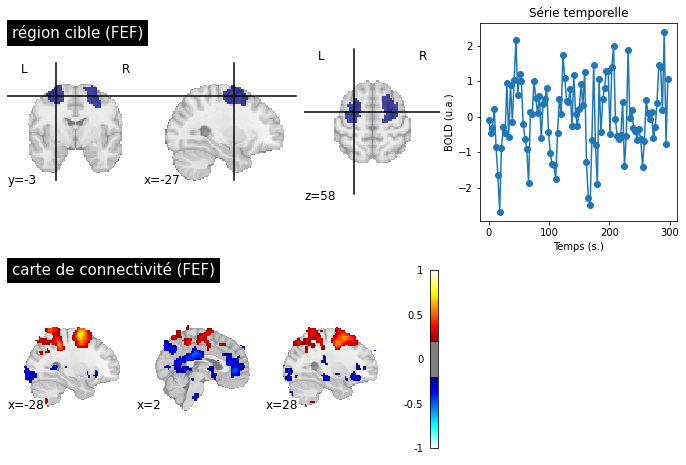

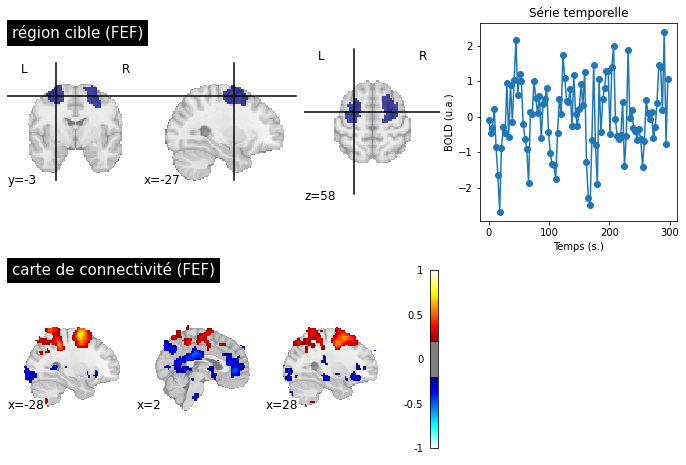

In [3]:
# Importe les librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets
from nilearn.image import math_img
from nilearn import image
from nilearn import masking
from nilearn.glm.first_level import FirstLevelModel
from nilearn import input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from nilearn import plotting

# initialisation de la figure
fig = plt.figure(figsize=(12,8))

# Importe les données
basc = datasets.fetch_atlas_basc_multiscale_2015() # the BASC multiscale atlas
adhd = datasets.fetch_adhd(n_subjects=10)          # ADHD200 preprocessed data (Athena pipeline)\

# Paramètres du pré-traitement
num_data = 1
fwhm = 8
high_pass = 0.01
high_variance_confounds = False
time_samp = range(0, 100)

# Extrait le signal par parcelle pour un atlas fonctionnel (BASC)
masker = input_data.NiftiLabelsMasker(
                                      basc['scale122'],
                                      resampling_target="data",
                                      high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      memory_level=1,
                                      smoothing_fwhm=fwhm).fit()
tseries = masker.transform(adhd.func[num_data])
print(f"Time series with shape {tseries.shape} (# time points, # parcels))")

# Charge les données par voxel
masker_voxel = input_data.NiftiMasker(high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      smoothing_fwhm=fwhm
                                     ).fit(adhd.func[num_data])
tseries_voxel = masker_voxel.transform(adhd.func[num_data])
print(f"Time series with shape {tseries_voxel.shape} (# time points, # voxels))")

# Applique une correction du signal global
from nilearn.signal import clean as signal_clean
gb_signal = signal_clean(
                        tseries.mean(axis=1).reshape([tseries.shape[0], 1]),
                        high_pass=high_pass,
                        t_r=3,
                        standardize=True)
tseries = masker.transform(adhd.func[num_data], confounds=gb_signal)
tseries_voxel = masker_voxel.transform(adhd.func[num_data], confounds=gb_signal)

# Montre une parcelle
ax_plot = plt.subplot2grid((2, 3), (0, 0), colspan=2)
num_parcel = 113
plotting.plot_roi(math_img(f'img == {num_parcel}', img=basc['scale122']),
                  threshold=0.5,
                  axes=ax_plot,
                  vmax=1,
                  title="région cible (FEF)")

# plot la série temporelle d'une région
ax_plot = plt.subplot2grid((2, 3), (0, 2), colspan=1)
time = np.linspace(0, 3 * (tseries.shape[0]-1), tseries.shape[0])
plt.plot(time[time_samp], tseries[time_samp, :][:, num_parcel], 'o-'),
plt.xlabel('Temps (s.)'),
plt.ylabel('BOLD (u.a.)')
plt.title('Série temporelle')

# carte de connectivité
ax_plot = plt.subplot2grid((2, 3), (1, 0), colspan=2)
seed_to_voxel_correlations = (np.dot(tseries_voxel.T, tseries[:, num_parcel-1]) / tseries.shape[0])# Show the connectivity map
conn_map = masker_voxel.inverse_transform(seed_to_voxel_correlations.T)
plotting.plot_stat_map(conn_map,
                       threshold=0.2,
                       vmax=1,
                       axes=ax_plot,
                       cut_coords=(-28, 2, 28),
                       display_mode = 'x',
                       title="carte de connectivité (FEF)")

# Glue the figure
from myst_nb import glue
glue("negative-DMN-fig", fig, display=False)

```{glue:figure} negative-DMN-fig
:figwidth: 600px
:name: negative-DMN-fig
:align: center
  Une région cible est sélectionnée au niveau "frontal eye field" (FEF), pour générer une carte de connectivité sur un sujet du jeu de données ADHD-200 {cite:p}`HD-200_Consortium2012-uv`. Le seuil de significativité est sélectionné de manière libérale (`|r|>0.2`). En plus du réseau attentional dorsal associé au FEF, la carte de connectivité met en évidence une corrélation négative avec le PCC et le cortex cingulaire antérieure (ACC). L'ACC et le PCC sont des régions clés du réseau du mode par défaut. Cette figure est générée par du code python à l'aide de la librairie [nilearn](https://nilearn.github.io/) (cliquer sur + pour voir le code), et est distribuée sous licence CC-BY.
```
Le réseau du mode par défaut n'est pas le seul que l'on puisse identifier au repos. On a déjà vu le réseau sensorimoteur qui a été le premier identifié par Biswal. Un autre réseau couramment examiné dans la litérature est le réseau attentionel dorsal (DAN), qui comprend notamment les sillons intra-pariétaux supérieurs (IPS) et les champs occulaires frontaux (FEF). Le DAN est souvent identifié comme activé dans les expériences utilisant une tâche cognitivement demandante en IRMf, et est parfois appelé le "task positive network" - même s'il n'est pas positivement engagé par toutes les tâches. En 2005, Fox et collègues {cite:p}`Fox2005-ge` remarquent une corrélation négative entre le DAN et le réseau du mode par défaut. Cette analyse renforce la notion de transitions spontanées entre un état mental dirigé vers les stimuli extérieurs, et un état introspectif, reflétant la compétition entre deux réseaux distribués.
```{admonition} Controverses sur la régression du signal global
:class: caution attention
:name: negative-r-warning
Les corrélations négatives de la {numref}`negative-DMN-fig` sont fortes uniquement quand on applique certaines étapes de débruitage des données, et notamment la _régression du signal global_. Une controverse importante est née autour des connexions négatives, car certains chercheurs pensent qu'il s'agit d'un artefact lié à cette étape de prétraitement. Malgré tout, les corrélations négatives peuvent être observées de manière robuste pour les sujets qui bougent très peu, et dont le signal est donc particulièrement propre. Leur amplitude est cependant faible en l'absence de régression du signal global.
```
```{admonition} Activité intrinsèque vs extrinsèque
:class: tip
:name: intrinseque-tip
Les réseaux au repos peuvent être observés même en présence d'une tâche. Plutôt qu'opposer la notion de repos et de tâche, il est courant de parler d'activité intrinsèque et extrinsèque. L'**activité extrinséque** est l'activité évoquée par une tâche, et reflète la manière dont l'environnement influence l'activité cérébrale. En revanche, l'**activité intrinsèque** désigne l'activité cérébrale qui émerge spontanément, et est indépendante des stimuli extérieurs. Les deux types d'activité sont toujours présentes, en peuvent interagir l'une avec l'autre.
```

## Réseaux fonctionnels

Time series with shape (176, 122) (# time points, # parcels))


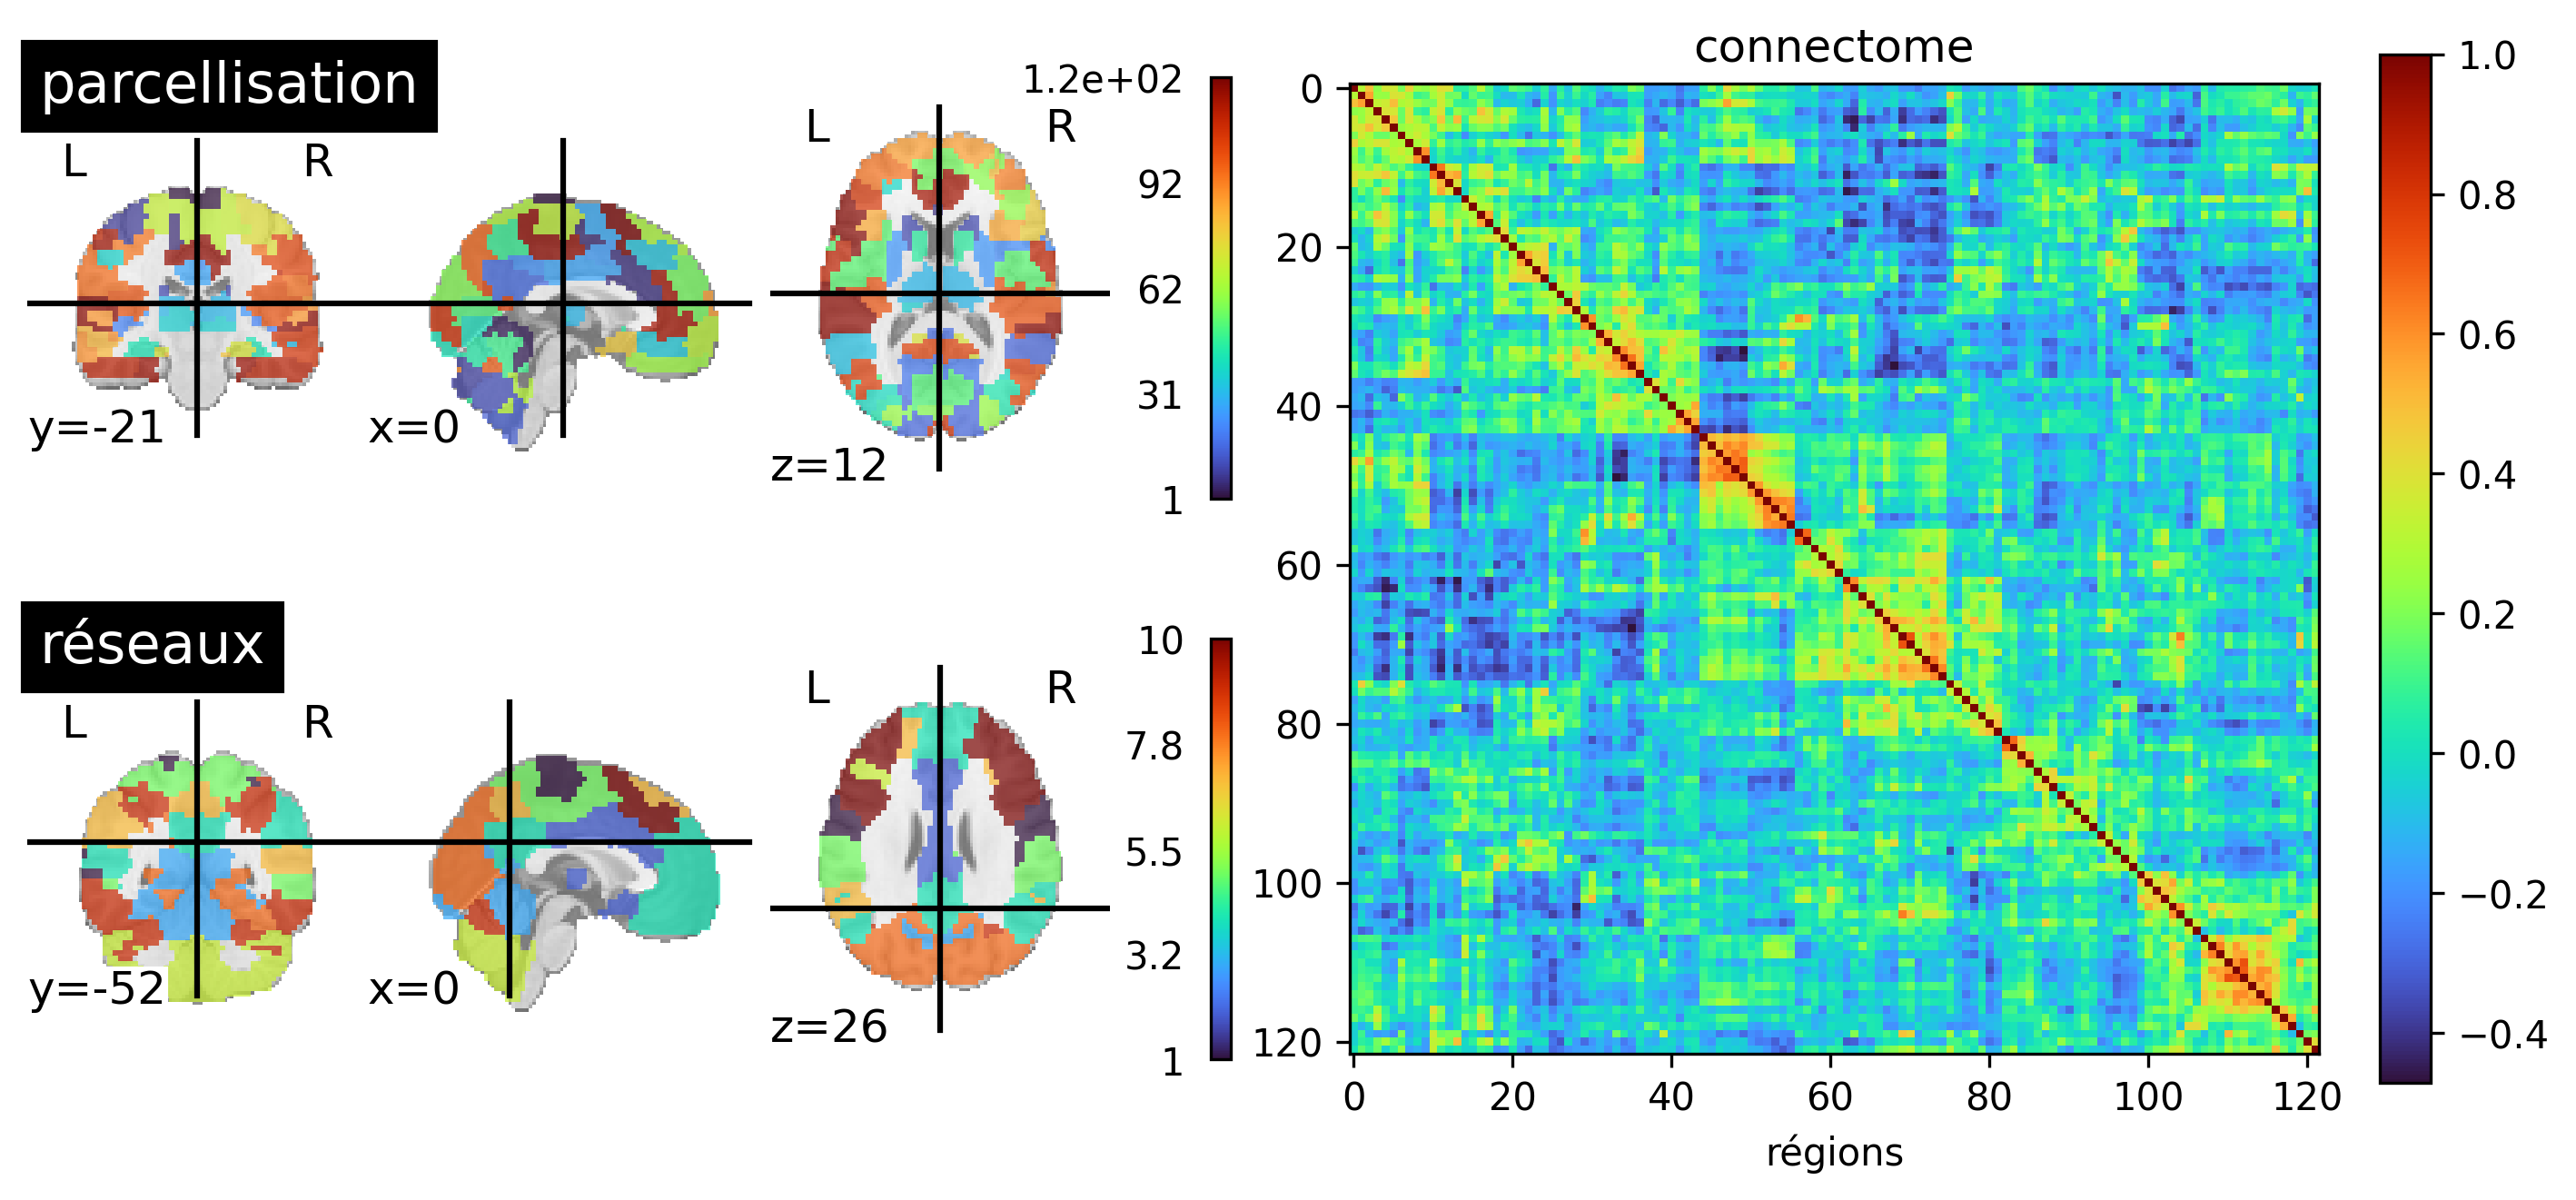

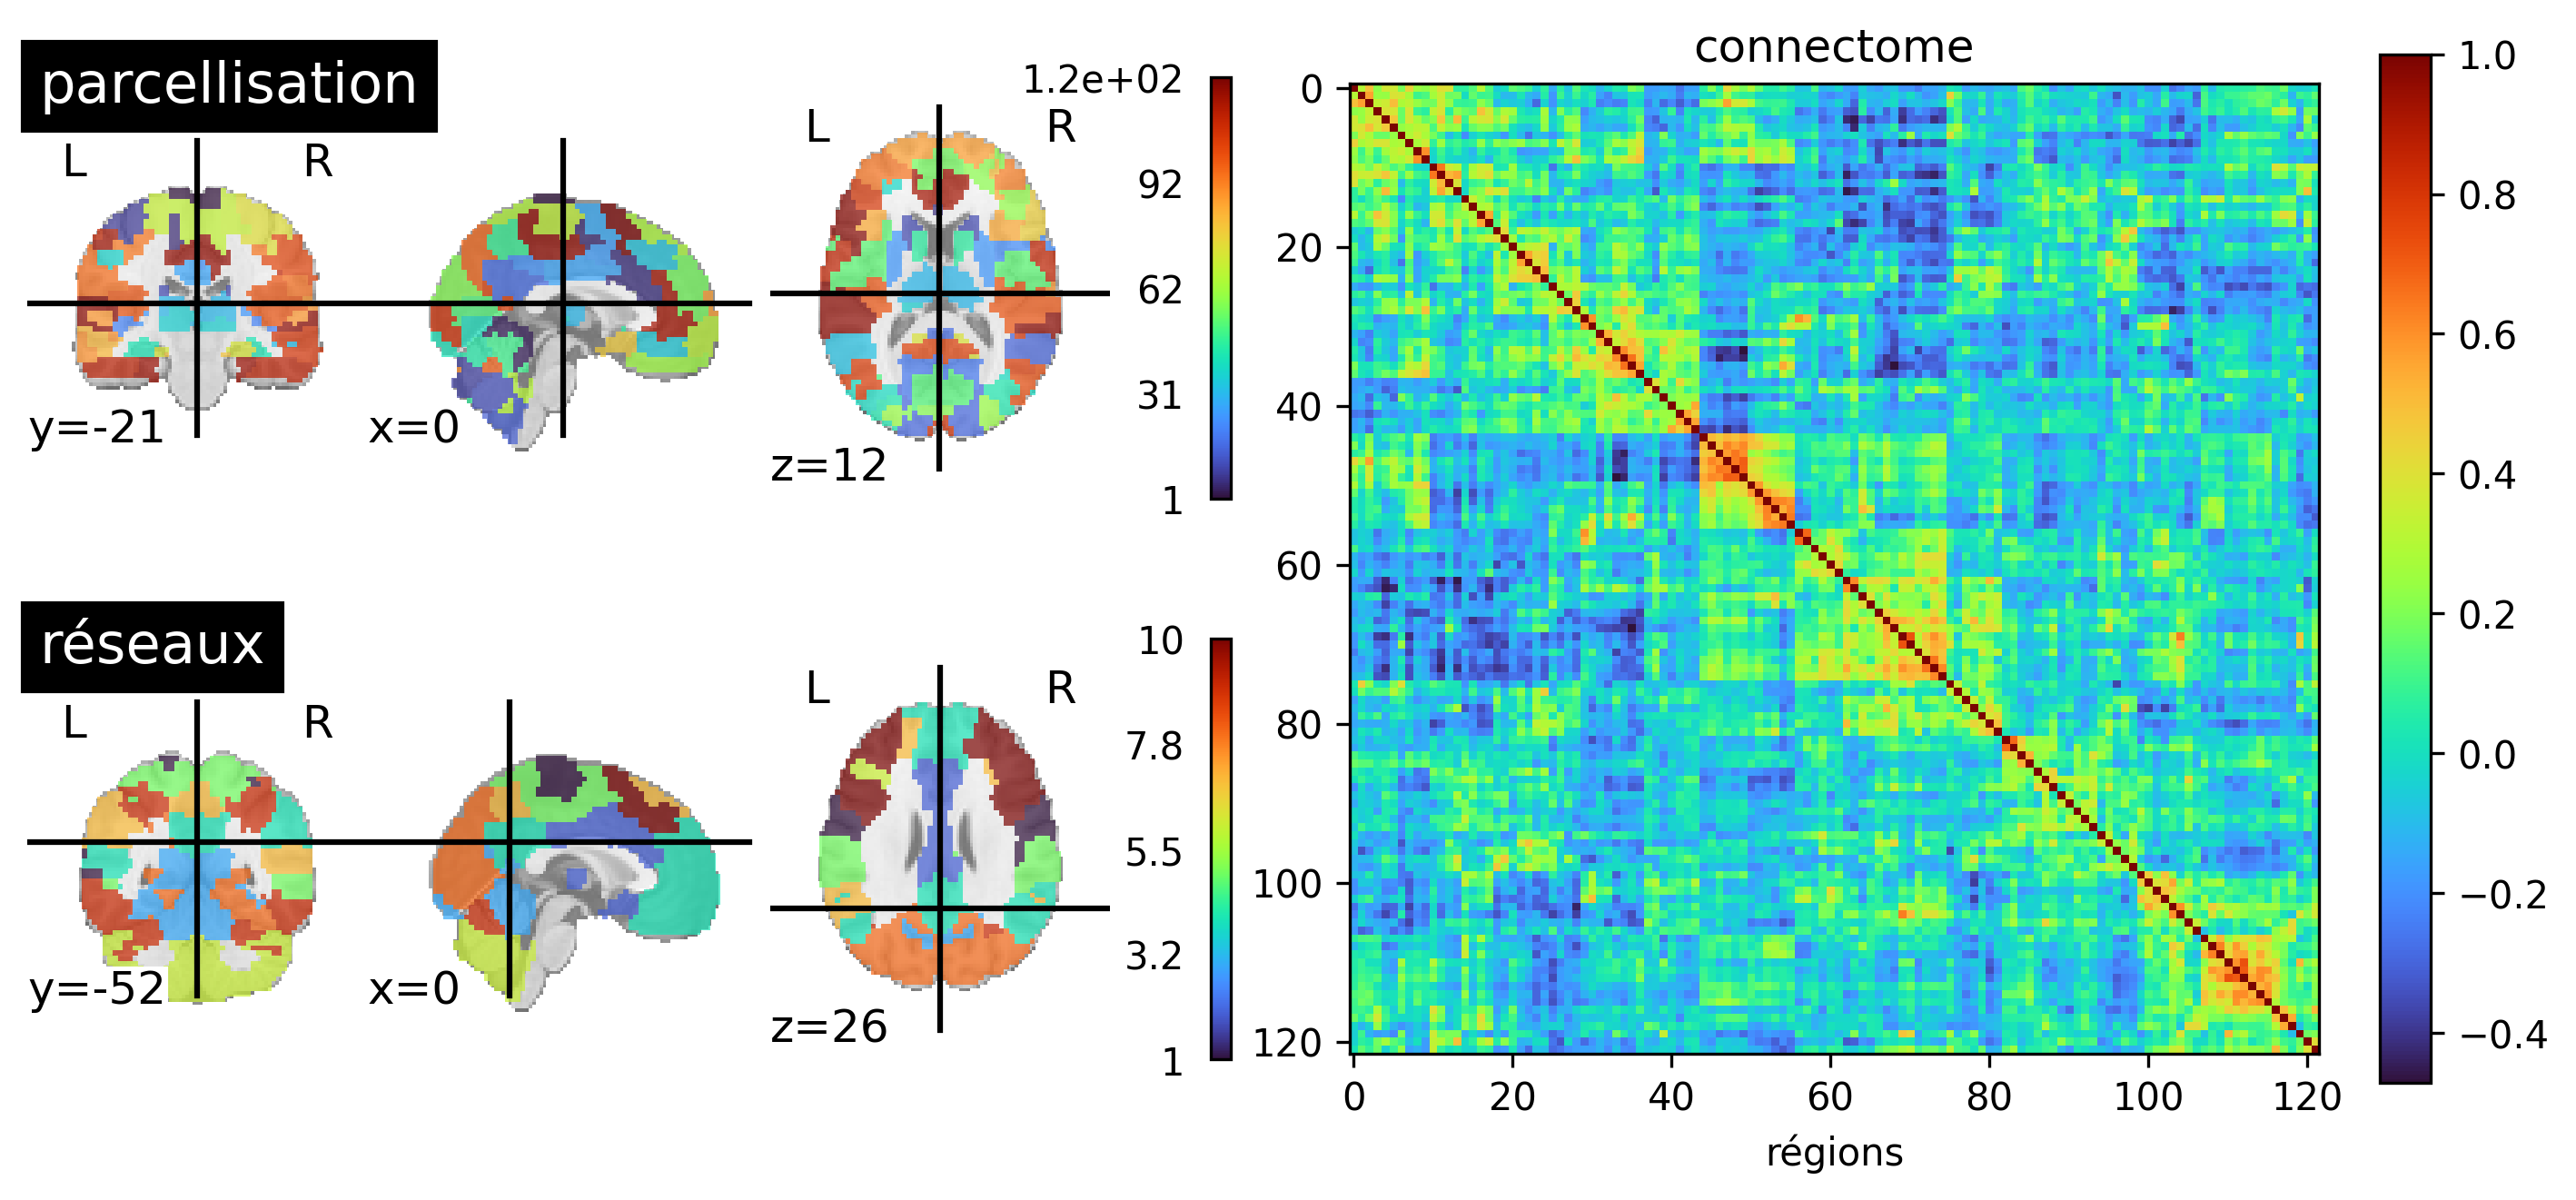

In [4]:
# Importe les librairies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import datasets
from nilearn.image import math_img
from nilearn import image
from nilearn import masking
from nilearn.glm.first_level import FirstLevelModel
from nilearn import input_data
from nilearn.input_data import NiftiLabelsMasker
from nilearn.input_data import NiftiMasker
from nilearn import plotting

# initialisation de la figure
fig = plt.figure(figsize=(12, 5), dpi=300)

# Importe les données
basc = datasets.fetch_atlas_basc_multiscale_2015() # the BASC multiscale atlas
adhd = datasets.fetch_adhd(n_subjects=10)          # ADHD200 preprocessed data (Athena pipeline)\

# Paramètres du pré-traitement
num_data = 1
fwhm = 8
high_pass = 0.01
high_variance_confounds = False
time_samp = range(0, 100)

# Extrait le signal par parcelle pour un atlas fonctionnel (BASC)
masker = input_data.NiftiLabelsMasker(
                                      basc['scale122'],
                                      resampling_target="data",
                                      high_pass=high_pass,
                                      t_r=3,
                                      high_variance_confounds=high_variance_confounds,
                                      standardize=True,
                                      memory='nilearn_cache',
                                      memory_level=1,
                                      smoothing_fwhm=fwhm).fit()
tseries = masker.transform(adhd.func[num_data])
print(f"Time series with shape {tseries.shape} (# time points, # parcels))")


# Applique une correction du signal global
from nilearn.signal import clean as signal_clean
gb_signal = signal_clean(
                        tseries.mean(axis=1).reshape([tseries.shape[0], 1]),
                        high_pass=high_pass,
                        t_r=3,
                        standardize=True)
tseries = masker.transform(adhd.func[num_data], confounds=gb_signal)

# Affiche le template
ax_plot = plt.subplot2grid((2, 4), (0, 0), colspan=2)
plotting.plot_roi(basc['scale122'], title="parcellisation", axes=ax_plot, colorbar=True, cmap="turbo")

# We generate a connectome
from nilearn.connectome import ConnectivityMeasure
conn = np.squeeze(ConnectivityMeasure(kind='correlation').fit_transform([tseries]))

# we use scipy's hierarchical clustering implementation
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
# That's the hierarchical clustering step
hier = linkage(conn, method='average', metric='euclidean') # scipy's hierarchical clustering
# HAC proceeds by iteratively merging brain regions, which can be visualized with a tree
res = dendrogram(hier, get_leaves=True, no_plot=True) # Generate a dendrogram from the hierarchy
order = res.get('leaves') # Extract the order on parcels from the dendrogram
part = np.squeeze(cut_tree(hier, n_clusters=10))

# Montre le connectome
ax_plot = plt.subplot2grid((2, 4), (0, 2), rowspan=2, colspan=2)
ax_plot.set_xlabel('régions')
ax_plot.set_title('connectome')
pos = ax_plot.imshow(conn[order, :][:, order], cmap='turbo', interpolation='nearest')
fig.colorbar(pos, ax=ax_plot)

# Montre les réseaux
ax_plot = plt.subplot2grid((2, 4), (1, 0), colspan=2)
part_img = masker.inverse_transform(part.reshape([1, 122]) + 1) # note the sneaky shift to 1-indexing
plotting.plot_roi(part_img,
                  title="réseaux",
                  colorbar=True,
                  cmap="turbo",
                  axes=ax_plot,
                  cut_coords=[0, -52, 26])

# Glue the figure
from myst_nb import glue
glue("network-fig", fig, display=False)

```{glue:figure} network-fig
:figwidth: 800px
:name: network-fig
:align: center
  Une parcellisation fonctionnelle du cerveau avec 122 parcelles est présentée à gauche (BASC). Au centre, on voit une matrice où chaque élément représente la corrélation entre l'activité de deux parcelles. Les parcelles ont été ordonnées de manière à mettre en évidence des carrés diagonaux: ce sont des groupes de régions dont l'activité corrèlent fortement entre elles, et peu avec le reste du cerveau. Des algorithmes de type clustering permettent de détecter automatiquement ces groupes de parcelles, appelés réseaux fonctionnels. Un exemple de réseaux fonctionnels générés avec un clustering hiérachique est présenté à droite, qui identifie notamment le réseau du mode par défaut. Cette figure est générée par du code python à l'aide de la librairie [nilearn](https://nilearn.github.io/) (cliquer sur + pour voir le code), et est distribuée sous licence CC-BY.
```
Dans la dernière section, nous avons parlé à plusieurs reprises de ***réseau fonctionnel***, mais sans vraiment définir ce que c'est. Lorsqu'on utilise une carte de connectivité, le réseau fonctionnel est l'ensemble des régions qui apparaissent dans la carte, et qui sont donc connectées à notre région cible. Mais cette approche dépend de la région cible. Pourtant, il est intuitif que toutes les cartes de connectivité utilisant des cibles dans, par exemple, le mode par défaut vont se ressembler. Pour formaliser cette intuition, nous avons besoin d'introduire la notion de connectome fonctionnel.

Un **connectome fonctionnel** est une matrice qui représente toutes les connexions (fonctionnelles) du cerveau. On commence donc par sélectionner une parcellisation cérébrale, puis l'on calcule la corrélation de l'activité temporelle pour toutes les paires de parcelles dans le cerveau. Cette matrice de corrélation est de taille `#parcelles x #parcelles`. En utilisant des techniques d'apprentissage non-supervisé, de type clustering, il est possible d'identifier des groupes de parcelles qui sont fortement connectées les unes aux autres, et peu connectées au reste du cerveau. C'est la définition la plus courant d'un réseau fonctionnel. Ce type d'approche permet de découper le cerveau en réseaux, de manière automatique et guidée par les données.

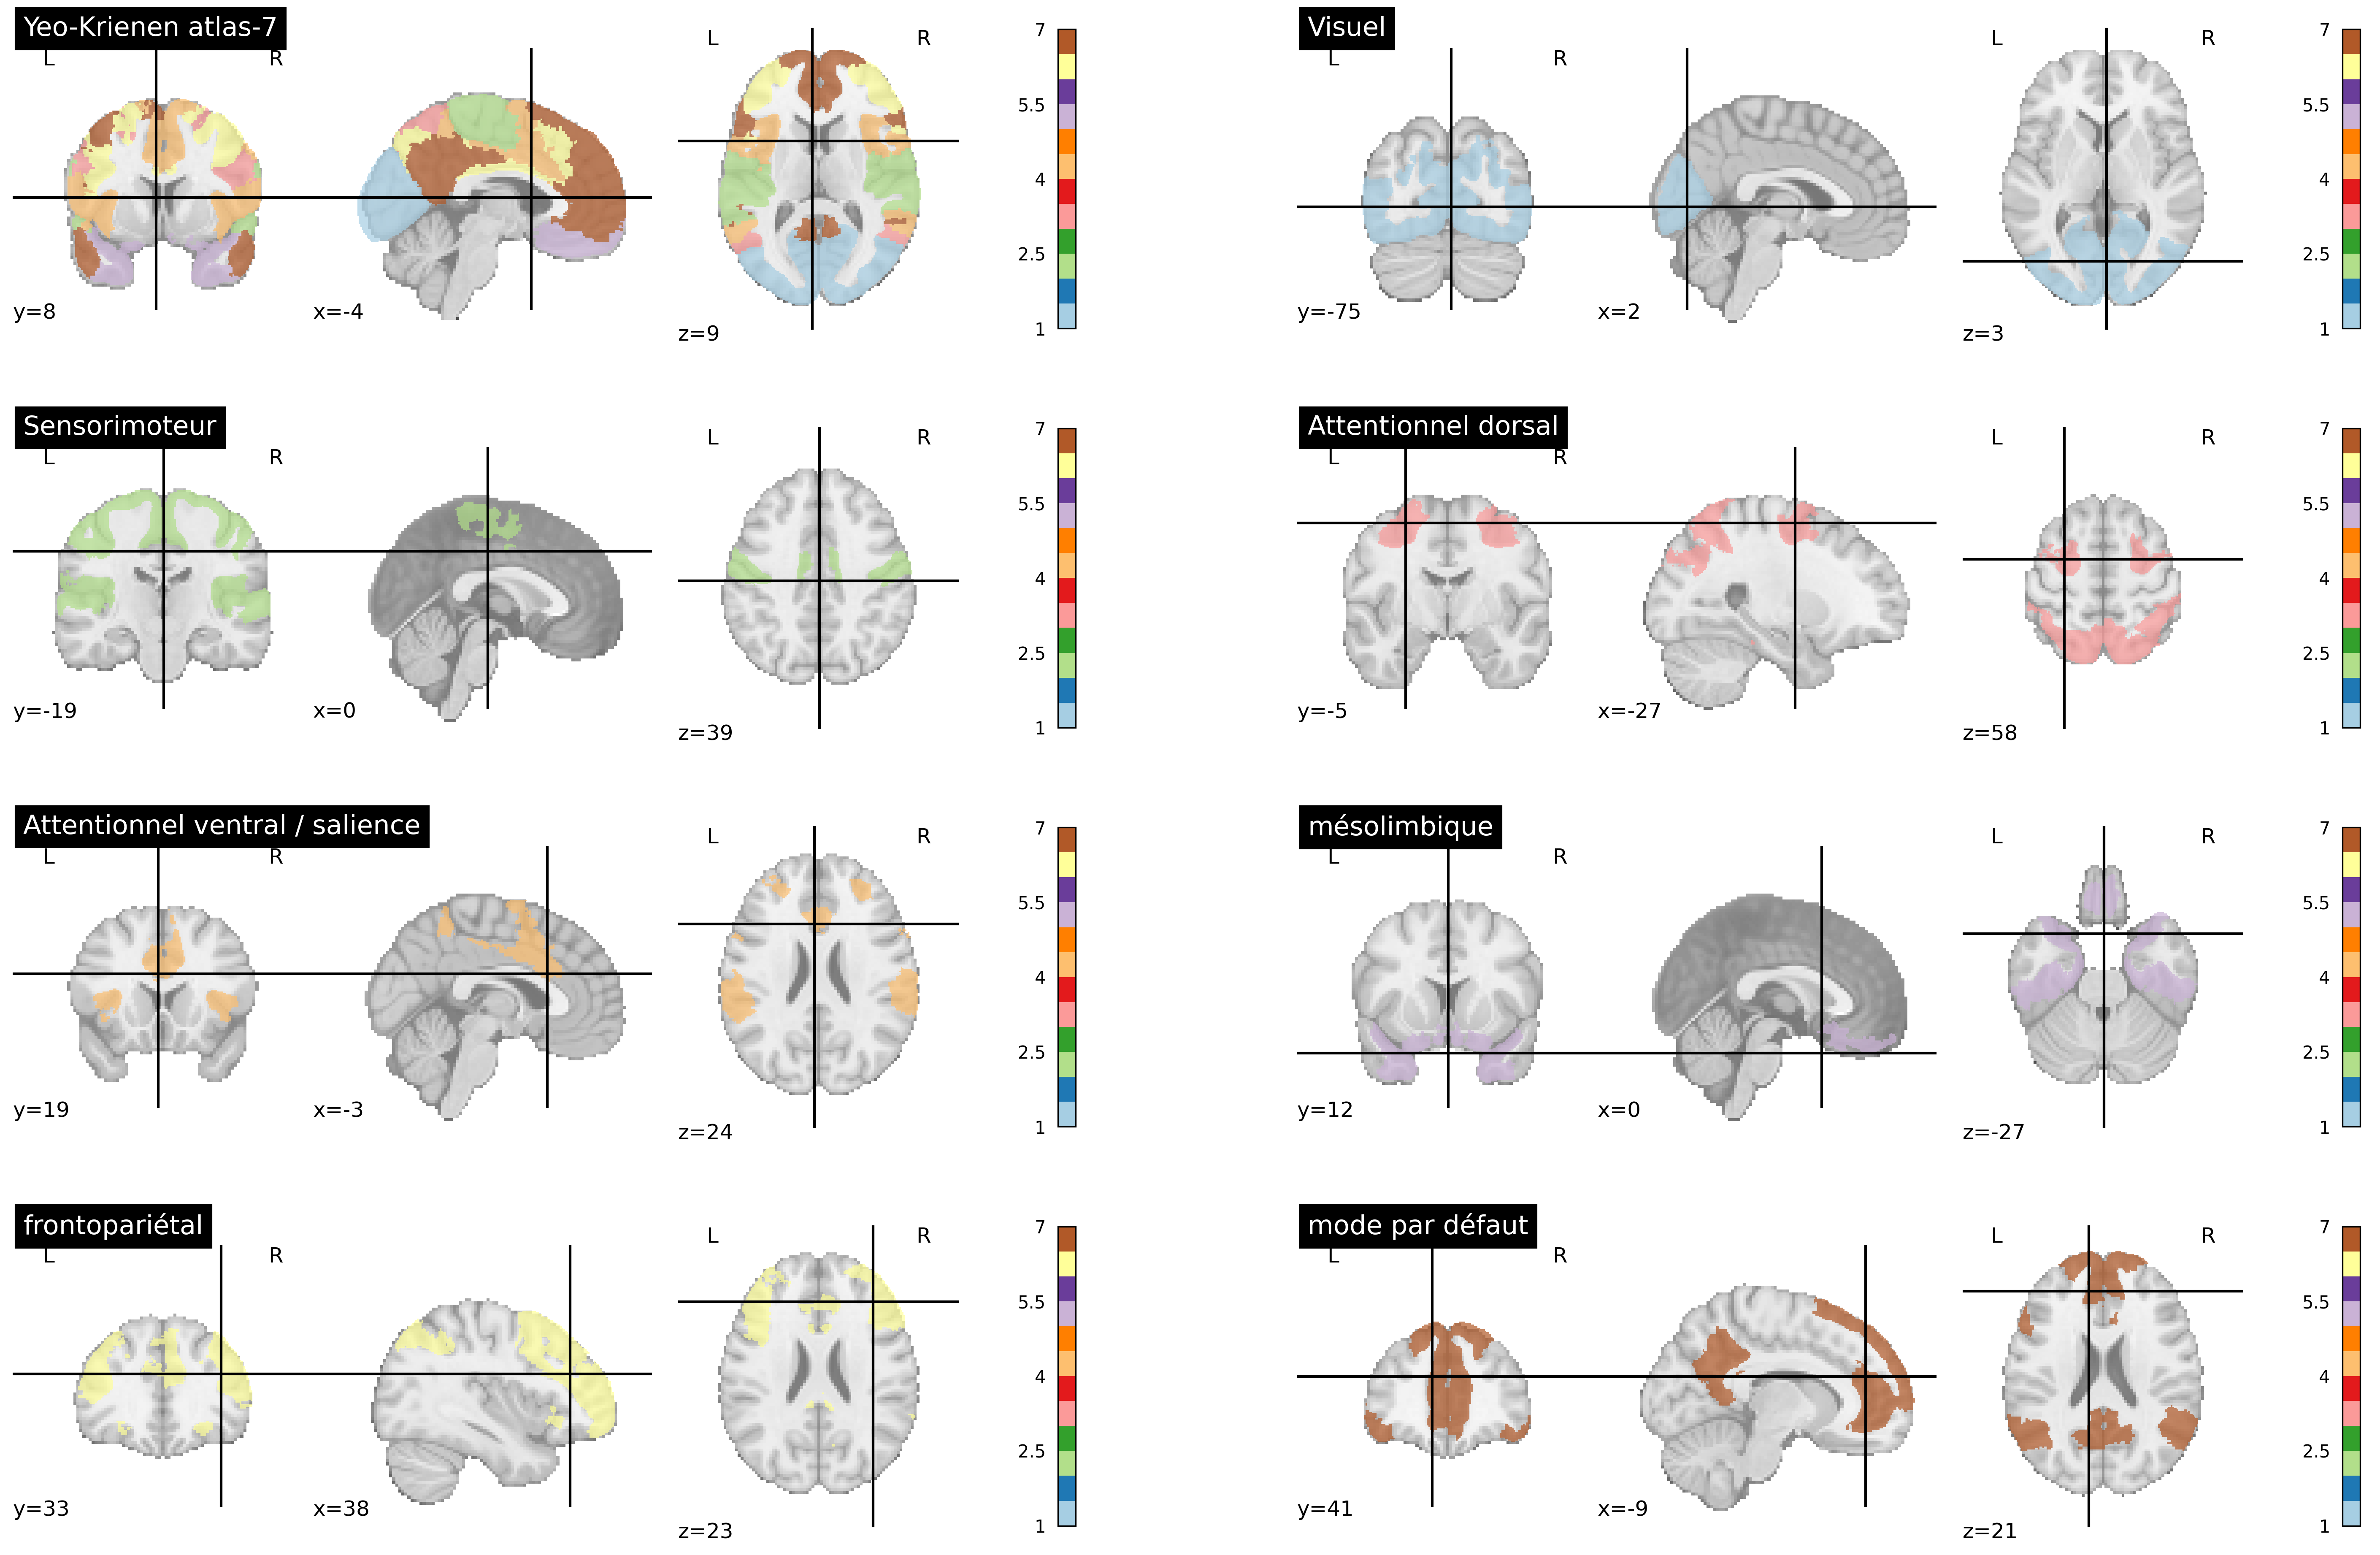

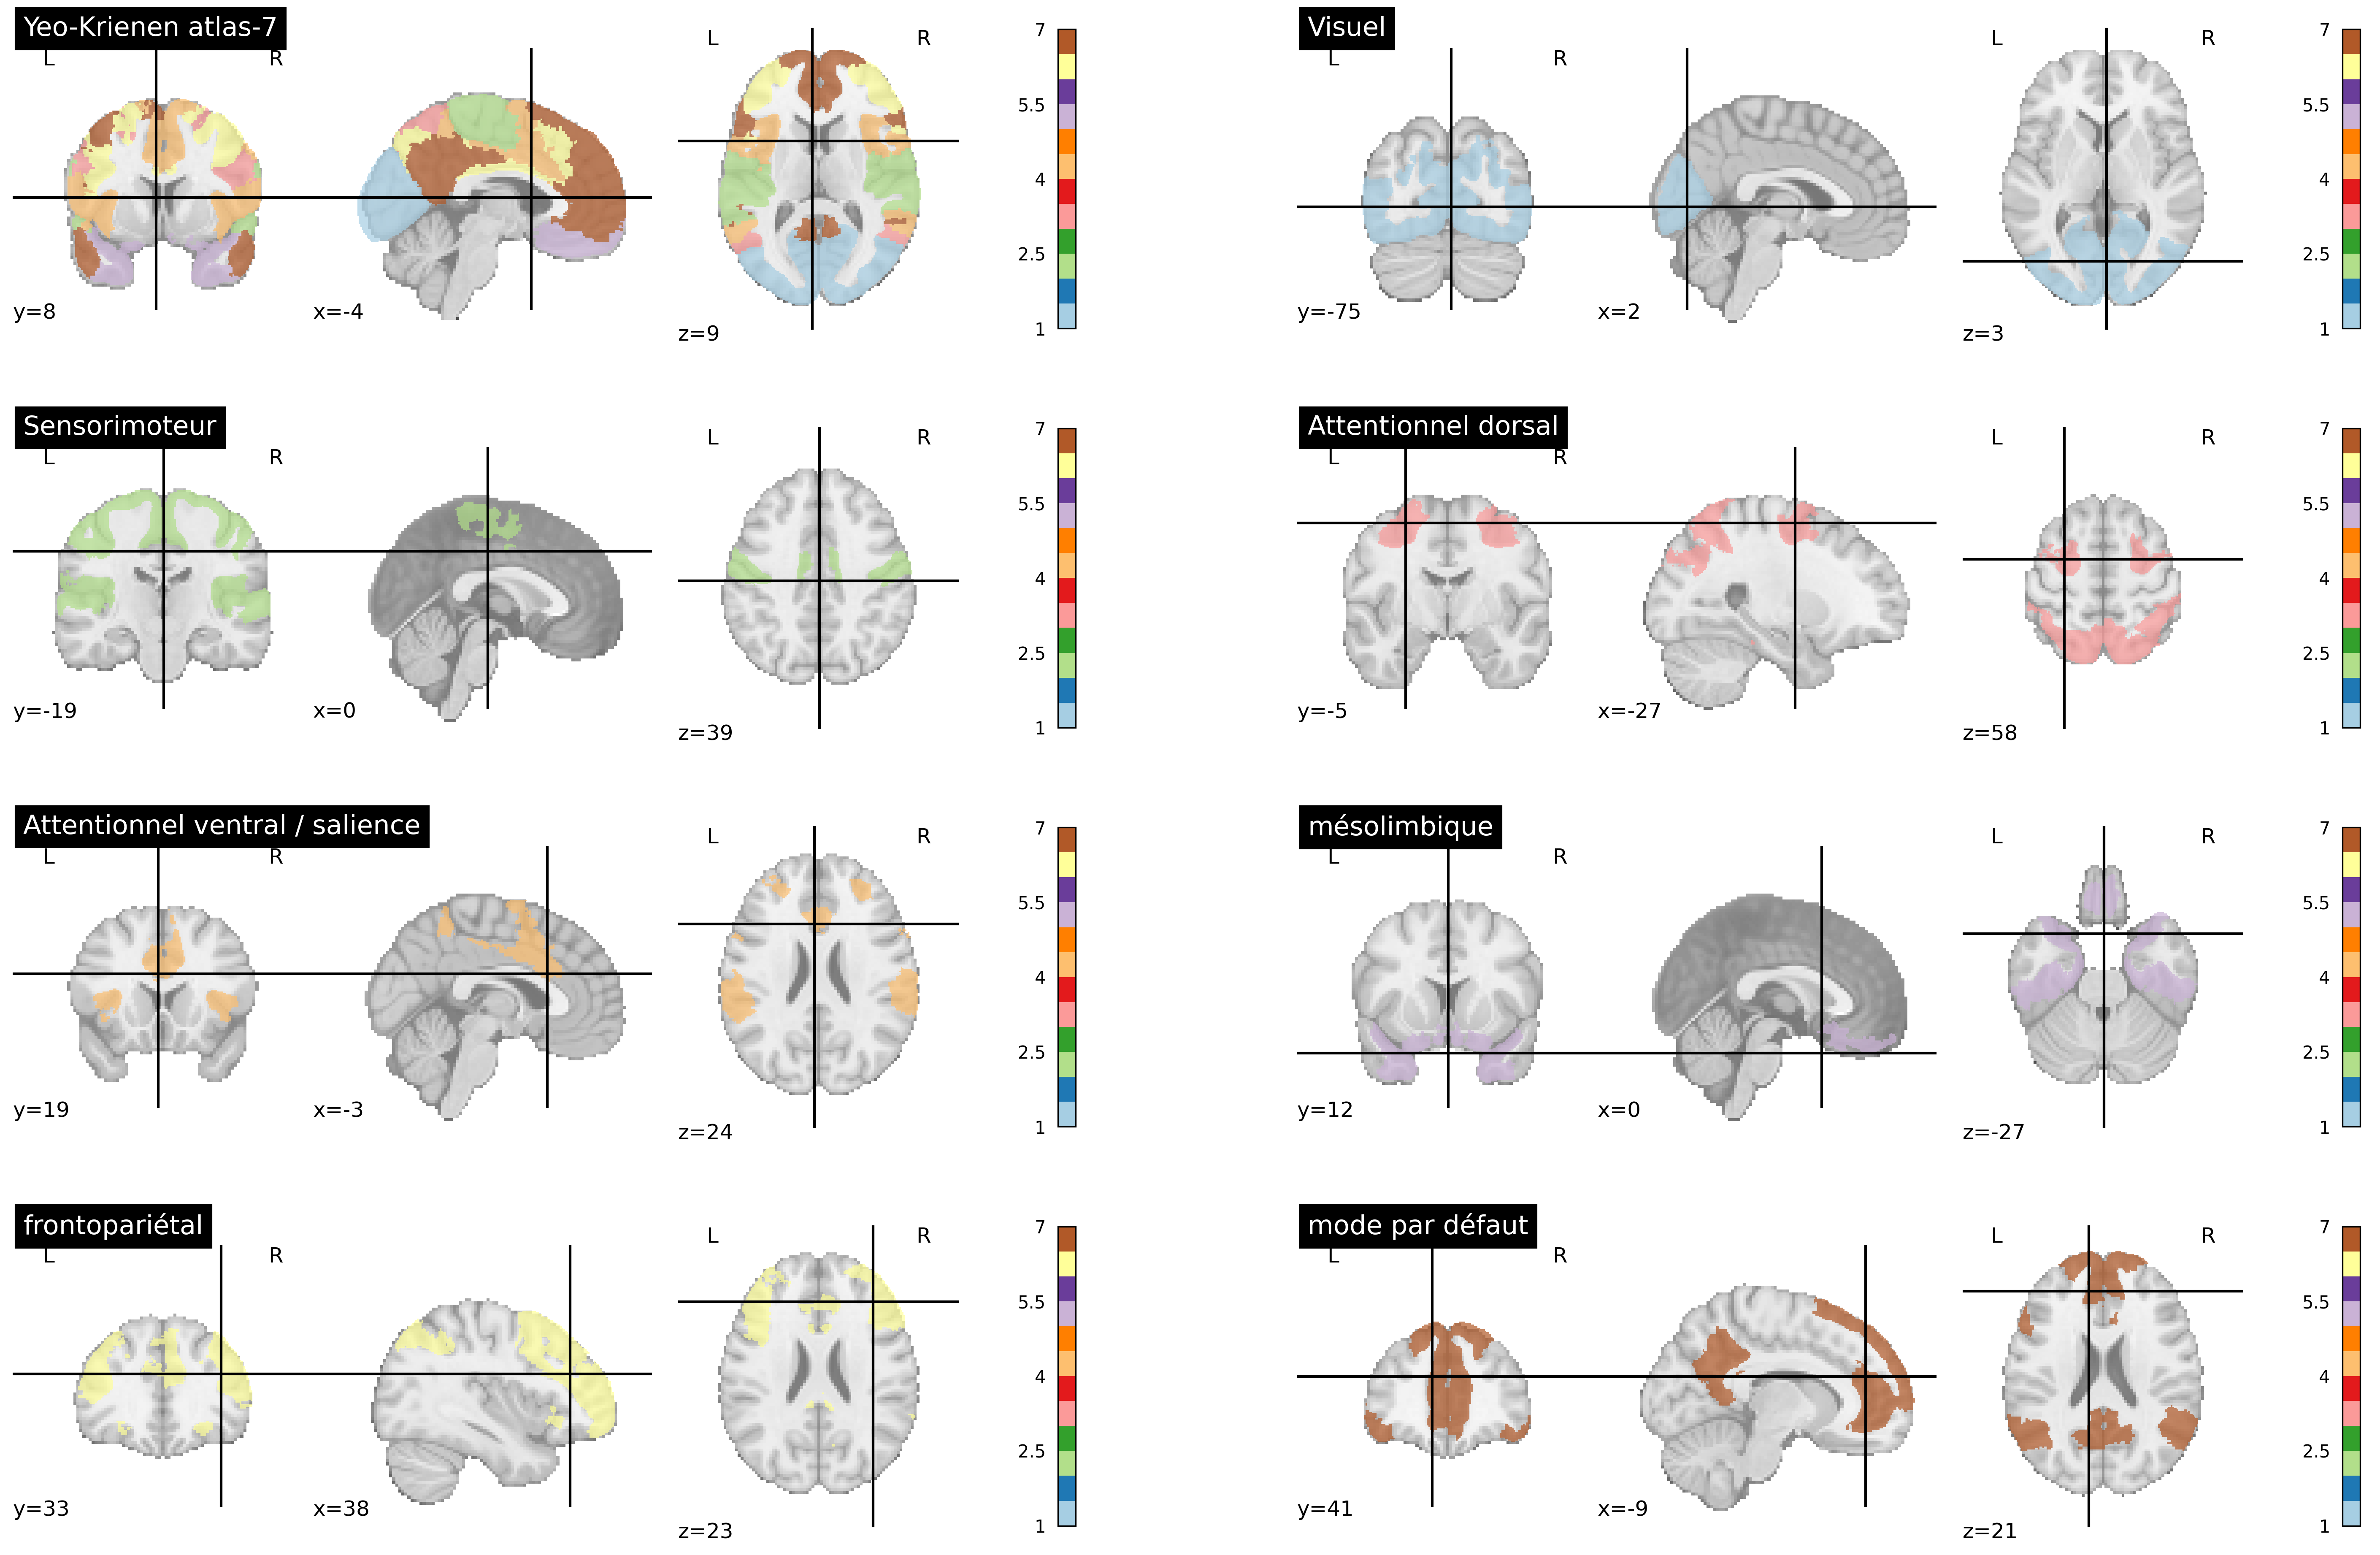

In [5]:
import warnings
warnings.filterwarnings("ignore")

from nilearn import datasets # Fetch data using nilearn
atlas_yeo = datasets.fetch_atlas_yeo_2011()        # the Yeo-Krienen atlas

# initialisation de la figure
fig = plt.figure(figsize=(24, 16), dpi=300)

# Let's plot the Yeo-Krienen 7 clusters parcellation
from nilearn import plotting
from nilearn.image import math_img
import matplotlib.pyplot as plt
ax_plot = plt.subplot(4, 2, 1)
plotting.plot_roi(atlas_yeo.thick_7, title='Yeo-Krienen atlas-7',
                  colorbar=True, cmap='Paired', axes=ax_plot)

ax_plot = plt.subplot(4, 2, 2)
plotting.plot_roi(math_img('(img==1).astype(\'float\')', img=atlas_yeo.thick_7), title='Visuel',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 3)
plotting.plot_roi(math_img('2 * (img==2).astype(\'float\')', img=atlas_yeo.thick_7), title='Sensorimoteur',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 4)
plotting.plot_roi(math_img('3 * (img==3).astype(\'float\')', img=atlas_yeo.thick_7), title='Attentionnel dorsal',
                  cut_coords=(-27, -5, 58), colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 5)
plotting.plot_roi(math_img('4 * (img==4).astype(\'float\')', img=atlas_yeo.thick_7), title='Attentionnel ventral / salience',
                  cut_coords=(-3, 19, 24), colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 6)
plotting.plot_roi(math_img('5 * (img==5).astype(\'float\')', img=atlas_yeo.thick_7), title='mésolimbique',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 7)
plotting.plot_roi(math_img('6 * (img==6).astype(\'float\')', img=atlas_yeo.thick_7), title='frontopariétal',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

ax_plot = plt.subplot(4, 2, 8)
plotting.plot_roi(math_img('7 * (img==7).astype(\'float\')', img=atlas_yeo.thick_7), title='mode par défaut',
                  colorbar=True, cmap='Paired', axes=ax_plot, vmin=1, vmax=7)

# Glue the figure
from myst_nb import glue
glue("yeo-krienen-fig", fig, display=False)

```{glue:figure} yeo-krienen-fig
:figwidth: 800px
:name: yeo-krienen-fig
:align: center
  Atlas de Yeo-Krienen {cite:p}`Yeo2011-sc` construit par une analyse de clustering à partir de données IRMf au repos d'un grand nombre de sujets. Les réseaux sont définis à plusieurs résolutions dans cet atlas (7 et 17). Ici, le découpage en 7 grands réseaux distribués est présenté. Cette figure est générée par du code python à l'aide de la librairie [nilearn](https://nilearn.github.io/) (cliquer sur + pour voir le code), et est distribuée sous licence CC-BY.
```
Il n'y a pas un nombre exact de réseaux cérébraux, mais plutôt une hiérarchie de réseaux plus ou moins spécialisés. Malgré tout, de nombreux articles ont étudiés un découpage en 7 réseaux corticaux. L'atlas de Yeo, Krienen et collègues {cite:p}`Yeo2011-sc` est très utilisé, et identifient sept grands réseaux. Certains de ces réseaux ont déjà été discutés dans ce chapitre: mode par défaut, attentionnel dorsal, sensorimoteur. Il faut ajouter deux autres réseaux associatifs: le frontopariétal et l'attentionnel ventral (parfois appelé salince). Il y a également un réseau visuel, et un réseau mésolimbique impliquant le pôle temporal et le cortex orbitofrontal. Notez que cet atlas ignore toutes les structures sous-corticales. La même étude a proposé un découpage en 17 sous-réseaux. Vous pouvez utiliser cet [outil interactif](https://simexp.github.io/multiscale_dashboard/index.html) pour explorer l'organisation multi-échelle des réseaux fonctionnels de manière interactive, à l'aide de l'atlas MIST {cite:p}`Urchs2019-xc`.


## Conclusions
* La connectivité fonctionnelle consiste à mesurer la cohérence (corrélation) entre l’activité de deux régions (ou voxels) du cerveau.
* Une carte de connectivité fonctionnelle permet d'étudier la connectivité entre une région cible et le reste du cerveau.
* La connectivité fonctionnelle peut être observée au repos (activité spontanée), en l’absence de protocole expérimental. En général, on a une superposition de l’activité intrinséque (liée à l'activité spontanée) et extrinsèque (liée à l'environnement).
* La connectivité IRMf au repos a joué un rôle clé dans la découverte du réseau du mode par défaut.
* Un réseau fonctionnel est un groupe de régions dont l’activité spontanée présente une forte connectivité fonctionnelle intra-réseau, et une faible connectivité avec le reste du cerveau. Différents atlas des réseaux au repos existent, et à différentes échelles.

## Références

```{bibliography}
:filter: docname in docnames
```

## Exercices
On commence par des exercices de révisions, qui concernent la vidéo “resting-state network” suivante:

In [6]:
from IPython.display import HTML
import warnings
warnings.filterwarnings("ignore")

# Youtube
HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/_Iph3WW9UOU?start=18" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

```{admonition} Exercice 5.1.
:class: note
“La septième jour” (sic), extrait en français: 0:54 - 4:35
 1. Qui représente le jeune homme?
 2. À quel résultat fait-il référence?
 3. Qui représente la jeune femme?
 5. À quel résultat fait-elle référence?
 5. Pourquoi appeler ce film “la septième jour” (sic) ?
```

```{admonition} Traduction de l’extrait “Neuro-météorologie”: 4:48 - 5:30
:class: tip
:name: neuro-meteorologie-tip
Regardons quelle activité intrinsèque nous arrive pour cette fin de semaine.
Comme vous pouvez le voir ici, le mode par défaut et le réseau “tâche-positif” font leurs affaires habituelles, présent / absent, yin et yang. Cela ressemble à l’activité habituelle de rêverie et de concentration intense pour la fin de semaine.
Le mode par défaut semble un peu dominant.
Le visuel sera beau, le moteur sera beau, à moins qu’une fluctuation alcoolique soudaine nous arrive du sud.
L’imagerie satellite nous indique des turbulences dans la région du précunéus qui pourraient devenir très intéressantes en début de semaine.
Mais, comme l’a dit le philosophe latin (Sénèque, NDLR): le repos est loin d’être de tout repos.  
```

```{admonition} Exercice 5.2.
:class: note
“Neuro-météorologie”: 4:48 - 5:30
1.  De quels réseaux parle-t-on ici?
2.  Pourquoi qualifie-t-il le réseau du mode par défaut et le réseau “tâche-positif” de “Yin and yang”?
3.  Est ce qu’il manque des réseaux dans cette prévision?
4.  Pourquoi est-ce que les turbulences dans le précunéus (ou plutôt le cortex cingulaire postérieur) sont intéressantes?
```

```{admonition} Traduction de l’extrait “Hardball”: 8:01 - 9:46
:class: tip
:name: hardball-tip
 - Présentateur (Pr): “Bonjour, aujourd’hui nous avons avec nous deux chercheurs distingués, Dr Yann Schnizel et Dr Paul Salami. Prêt à débattre sans compromis?”
 - Paul Salami (PS): “Je souhaite dire que le développement de la littérature sur le mode par défaut et l’état de repos propose de bonnes questions, de bonnes expériences, et cela bénéficie pour l’essentiel aux jeunes qui démarrent la recherche, mais je ne pense pas personnellement qu’étudier le repos est particulièrement utile. Si vous voulez étudier le comportement, vous le faites de la façon traditionnelle, comme nous le faisions avant, vous le faites expérimentalement.”
 - Yann Schnizel (YS): “Ce n’est pas le cas! La distinction importante n’est pas entre repos et tâche, mais plutôt entre activité intrinsèque et évoquée.”
 - PS: “Si nous sommes tous les deux d’accord pour dire que l’activité spontanée est présente dans tous les états cognitifs, je ne vois pas pourquoi nous devrions spécifiquement, je dis bien spécifiquement!, dans un état de repos.”
 - YS: “Nous ne devons certainement pas l’étudier exclusivement au repos, mais l’état de repos est LA condition dans laquelle ces fluctuations spontanées ont été étudiées de la manière la plus détaillée.”
 - PS: “Ceci est fondamentalement non-psychologique!”
 - YS: “Non!”
 - PS: “non-psychologique!”
 - YS: “VOUS êtes fondamentalement non-psychologique!”
 - PS: “au moins j’étudie la cognition durant l’instant où l’événement cognitif se passe.”
 - Pr: “whaou messieurs, les esprits s’échauffent! Calmons nous un peu. Il semble qu’il ne nous reste plus de temps.”
(bataille entre PS et YS)
 - Pr: “La semaine prochaine, dans “cluster analysis”, nous partirons sur la route avec Michael Milham, chanteur folk légendaire. Il voyage de par le monde pour partager l’histoire des réseaux au repos, en chanson. Merci d’avoir regardé cluster analysis sur le réseau du repos,”
```

```{admonition} Exercice 5.3.
:class: note
“Hardball”: 8:01 - 9:46
 1. Est-il vrai que l’activité spontanée est présente aussi bien au repos que durant une tâche?
 2. Est-il vrai que l’activité spontanée a été principalement étudiée dans un état de repos en IRMf?
 3. En quoi est-il “non psychologique” d’étudier une condition de repos?
 4. Question ouverte: est ce que l’un d’entre eux a raison? Ou les deux?
```

```{admonition} Exercice 5.4.
:class: note
Carte de connectivité: vrai/faux
 1. Une carte de connectivité change si on change la région cible.
 2. Pour définir une région cible, on doit faire une carte d’activation.
 3. Une carte de connectivité fonctionnelle présente des valeurs entre 0 et 1.
 4. Une carte de connectivité en IRMf est un outil pour identifier le réseau du mode par défaut.
```

```{admonition} Exercice 5.5.
:class: note
Activité spontanée et évoquée: vrai/faux
 1. L’activité spontanée du cerveau ne s’observe que dans un état de repos.
 2. L’activité cérébrale évoquée par une tâche peut être caractérisée par une carte d’activation IRMf.
 3. L’activité spontanée du cerveau est plus importante au repos que pendant une tâche visuelle dans certaines parties du cerveau.
```

```{admonition} Exercice 5.6.
:class: note
Réseaux fonctionnels: vrai/faux
 1. Il y a exactement 7 réseaux fonctionnels dans le cerveau.
 2. Un réseau fonctionnel est composé de régions présentant une connectivité fonctionnelle forte.
 3. Le réseau du mode par défaut peut être identifié avec une carte d'activation.
 4. Les régions du réseau du mode par défaut sont corrélées négativement avec les régions du réseau sensorimoteur.
```

```{admonition} Exercice 5.7
:class: note
Pour répondre à cette question, lisez l'article de Shukla et collaborateurs, "_Aberrant Frontostriatal Connectivity in Negative Symptoms of Schizophrenia_", publié dans Schizophrenia Bulletin (2019, 45(5): 1051-59) et disponible en libre accès à cette [adresse](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6737477/). Les questions suivantes sont à développement court.
 * Quel logiciel a été utilisé pour analyser les données d'IRMf?
 * Quelle condition expérimentale était utilisée pendant les acquisitions d'IRMf?
 * Quel était le paramètre de lissage spatial?
 * Est-ce que les données ont été corrigées du mouvement? Pourquoi?
 * Est-ce que l'un des deux groupes a plus bougé que l'autre?
 * Quelles procédures de filtrage et correction de bruits ont été appliquées?
 * Dans quel espace stéréotaxique les analyses de groupe sont-elles effectuées?
 * Quel type de mesure de connectivité est utilisée dans l'article?
```

```{admonition} Exercice 5.8.
:class: note
On souhaite comparer la connectivité fonctionnelle entre des personnes jeunes et âgées. Citez trois facteurs de confusion potentiel, qui ne sont pas liés à l’activité neuronale intrinsèque.
```